In [6]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import numpy as np

Config

In [7]:
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 70
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

ORIG_DATA_DIR = r'E:\Projects\Krishi-Sahayak\krishi-model\Data'  # original dataset folder
DATA_DIR = r'E:\Projects\Krishi-Sahayak\krishi-model\SplitData' # folder where split dataset will be saved

Split Data

In [3]:
# def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
#     random.seed(seed)
#     assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

#     classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
#     print(f"Classes found: {classes}")

#     for cls in classes:
#         cls_path = os.path.join(source_dir, cls)
#         files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
#         random.shuffle(files)

#         n_total = len(files)
#         n_train = int(train_ratio * n_total)
#         n_val = int(val_ratio * n_total)
#         n_test = n_total - n_train - n_val

#         splits = {
#             'train': files[:n_train],
#             'val': files[n_train:n_train+n_val],
#             'test': files[n_train+n_val:]
#         }

#         for split_name, split_files in splits.items():
#             split_dir = os.path.join(dest_dir, split_name, cls)
#             os.makedirs(split_dir, exist_ok=True)

#             for file_name in split_files:
#                 src_file = os.path.join(cls_path, file_name)
#                 dst_file = os.path.join(split_dir, file_name)
#                 if not os.path.exists(dst_file):
#                     shutil.copy2(src_file, dst_file)
#             print(f"Copied {len(split_files)} files to {split_dir}")

In [4]:
# split_data(ORIG_DATA_DIR, DATA_DIR, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

Data Generators

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save labels for inference
os.makedirs("model", exist_ok=True)
with open("model/labels.txt", "w") as f:
    for label in train_generator.class_indices:
        f.write(f"{label}\n")

Found 7990 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.
Found 2674 images belonging to 17 classes.


Plant Validation

In [9]:
def is_leaf_colored(img, threshold=0.25):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype("float") / 255.0
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]

    green_mask = (G > R) & (G > B)
    yellow_mask = (R > 0.3) & (G > 0.3) & (B < 0.4) & (abs(R-G) < 0.2)
    brown_mask = (R > 0.4) & (G > 0.2) & (B < 0.3)

    valid_mask = green_mask | yellow_mask | brown_mask
    valid_ratio = np.sum(valid_mask) / (img.shape[0] * img.shape[1])
    return valid_ratio > threshold

def has_leaf_texture(img, min_ratio=0.005):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / (img.shape[0] * img.shape[1])
    return edge_ratio > min_ratio

def background_check(img, var_threshold=0.001):
    img_norm = img.astype("float") / 255.0
    var = np.var(img_norm, axis=(0,1))
    avg_var = np.mean(var)
    return avg_var >= var_threshold

def validate_plant_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return False
    if not is_leaf_colored(img):
        return False
    if not has_leaf_texture(img):
        return False
    if not background_check(img):
        return False
    return True

Build Model

In [10]:
# Load MobileNetV3-Small base
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                              include_top=False,
                              weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze base initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('model/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

Initial training

In [12]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.4486 - loss: 1.7449
Epoch 1: val_loss improved from None to 2.38342, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 183s 714ms/step - accuracy: 0.5378 - loss: 1.3979 - val_accuracy: 0.3711 - val_loss: 2.3834 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6180 - loss: 1.0670
Epoch 2: val_loss improved from 2.38342 to 1.16753, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - accuracy: 0.6337 - loss: 1.0275 - val_accuracy: 0.6737 - val_loss: 1.1675 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6620 - loss: 0.9458
Epoch 3: val_loss improved from 1.16753 to 0.74665, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 159s 637ms/step - accuracy: 0.6650 - loss: 0.9339 - val_accuracy: 0.7226 - val_loss: 0.7466 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6819 - loss: 0.8634
Epoch 4: val_loss improved from 0.74665 to 0.69850, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 153s 614ms/step - accuracy: 0.6783 - loss: 0.8682 - val_accuracy: 0.7312 - val_loss: 0.6985 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7009 - loss: 0.8356
Epoch 5: val_loss improved from 0.69850 to 0.66314, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 626ms/step - accuracy: 0.6944 - loss: 0.8410 - val_accuracy: 0.7485 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6854 - loss: 0.8376
Epoch 6: val_loss improved from 0.66314 to 0.63220, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 668ms/step - accuracy: 0.6919 - loss: 0.8230 - val_accuracy: 0.7523 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7012 - loss: 0.7932
Epoch 7: val_loss did not improve from 0.63220
250/250 ━━━━━━━━━━━━━━━━━━━━ 164s 654ms/step - accuracy: 0.6970 - loss: 0.7975 - val_accuracy: 0.7346 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6975 - loss: 0.7912
Epoch 8: val_loss improved from 0.63220 to 0.62823, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 646ms/step - accuracy: 0.7020 - loss: 0.7804 - val_accuracy: 0.7575 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.7057 - loss: 0.7610
Epoch 9: val_loss did not improve from 0.62823
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 680ms/step - accuracy: 0.7083 - loss: 0.7623 - val_accuracy: 0.7425 - val_loss: 0.6451 - learning_rate: 0.0010
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.7239 - loss: 0.7296
Epoch 10: val_loss improved from 0.62823 to 0.59923, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 153s 612ms/step - accuracy: 0.7188 - loss: 0.7380 - val_accuracy: 0.7654 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7125 - loss: 0.7344
Epoch 11: val_loss did not improve from 0.59923
250/250 ━━━━━━━━━━━━━━━━━━━━ 152s 609ms/step - accuracy: 0.7153 - loss: 0.7343 - val_accuracy: 0.7598 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7174 - loss: 0.7457
Epoch 12: val_loss improved from 0.59923 to 0.59791, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 646ms/step - accuracy: 0.7185 - loss: 0.7256 - val_accuracy: 0.7695 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7201 - loss: 0.7102
Epoch 13: val_loss improved from 0.59791 to 0.57833, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - accuracy: 0.7250 - loss: 0.7135 - val_accuracy: 0.7726 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7411 - loss: 0.6932
Epoch 14: val_loss did not improve from 0.57833
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 643ms/step - accuracy: 0.7343 - loss: 0.7061 - val_accuracy: 0.7741 - val_loss: 0.5805 - learning_rate: 0.0010
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7356 - loss: 0.6916
Epoch 15: val_loss did not improve from 0.57833
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 648ms/step - accuracy: 0.7318 - loss: 0.6970 - val_accuracy: 0.7654 - val_loss: 0.5854 - learning_rate: 0.0010
Epoch 16/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7353 - loss: 0.6915
Epoch 16: val_loss improved from 0.57833 to 0.56780, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 648ms/step - accuracy: 0.7392 - loss: 0.6830 - val_accuracy: 0.7726 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 17/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.7365 - loss: 0.6770
Epoch 17: val_loss did not improve from 0.56780
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 644ms/step - accuracy: 0.7334 - loss: 0.6918 - val_accuracy: 0.7662 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 18/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7417 - loss: 0.6817
Epoch 18: val_loss improved from 0.56780 to 0.55100, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 648ms/step - accuracy: 0.7375 - loss: 0.6934 - val_accuracy: 0.7861 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 19/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7450 - loss: 0.6604
Epoch 19: val_loss did not improve from 0.55100
250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 647ms/step - accuracy: 0.7417 - loss: 0.6682 - val_accuracy: 0.7801 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7560 - loss: 0.6452
Epoch 20: val_loss improved from 0.55100 to 0.54403, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - accuracy: 0.7472 - loss: 0.6672 - val_accuracy: 0.7827 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 21/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7332 - loss: 0.6862
Epoch 21: val_loss did not improve from 0.54403
250/250 ━━━━━━━━━━━━━━━━━━━━ 160s 641ms/step - accuracy: 0.7385 - loss: 0.6772 - val_accuracy: 0.7805 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7480 - loss: 0.6460
Epoch 22: val_loss did not improve from 0.54403
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 648ms/step - accuracy: 0.7432 - loss: 0.6574 - val_accuracy: 0.7741 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 23/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7510 - loss: 0.6514
Epoch 23: val_loss improved from 0.54403 to 0.53542, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 0.7481 - loss: 0.6515 - val_accuracy: 0.7823 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 24/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7580 - loss: 0.6274
Epoch 24: val_loss did not improve from 0.53542
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 649ms/step - accuracy: 0.7506 - loss: 0.6410 - val_accuracy: 0.7801 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 25/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.7370 - loss: 0.6708
Epoch 25: val_loss did not improve from 0.53542
250/250 ━━━━━━━━━━━━━━━━━━━━ 150s 602ms/step - accuracy: 0.7442 - loss: 0.6574 - val_accuracy: 0.7726 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 26/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.7489 - loss: 0.6450
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 26: val_loss did not improve from 0.53542
250/250 ━━━━━━━━━━━━━━━━━━━━ 154s 615ms/step - accuracy: 0.7454 - loss: 0.64

250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 645ms/step - accuracy: 0.7631 - loss: 0.6160 - val_accuracy: 0.7865 - val_loss: 0.5325 - learning_rate: 5.0000e-04
Epoch 28/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7680 - loss: 0.6096
Epoch 28: val_loss improved from 0.53254 to 0.51859, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 0.7635 - loss: 0.6137 - val_accuracy: 0.7910 - val_loss: 0.5186 - learning_rate: 5.0000e-04
Epoch 29/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7779 - loss: 0.5962
Epoch 29: val_loss improved from 0.51859 to 0.50341, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 161s 644ms/step - accuracy: 0.7718 - loss: 0.6011 - val_accuracy: 0.7891 - val_loss: 0.5034 - learning_rate: 5.0000e-04
Epoch 30/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7633 - loss: 0.6050
Epoch 30: val_loss did not improve from 0.50341
250/250 ━━━━━━━━━━━━━━━━━━━━ 167s 668ms/step - accuracy: 0.7603 - loss: 0.6051 - val_accuracy: 0.7895 - val_loss: 0.5155 - learning_rate: 5.0000e-04
Epoch 31/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7666 - loss: 0.5985
Epoch 31: val_loss did not improve from 0.50341
250/250 ━━━━━━━━━━━━━━━━━━━━ 186s 745ms/step - accuracy: 0.7681 - loss: 0.5919 - val_accuracy: 0.7891 - val_loss: 0.5155 - learning_rate: 5.0000e-04
Epoch 32/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7715 - loss: 0.5928
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 32: val_loss did not improve from 0.50341
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 723ms/step - accuracy: 0.7722 

Fine-tuning

In [13]:
# Unfreeze last 20% of layers for fine-tuning
num_layers_to_unfreeze = int(len(model.layers) * 0.2)
for layer in model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

# Compile again with lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 37/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.3651 - loss: 8.6839
Epoch 37: val_loss did not improve from 0.50341
250/250 ━━━━━━━━━━━━━━━━━━━━ 165s 635ms/step - accuracy: 0.4667 - loss: 4.7724 - val_accuracy: 0.0677 - val_loss: 191.3344 - learning_rate: 1.0000e-04
Epoch 38/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.5695 - loss: 2.0800
Epoch 38: val_loss did not improve from 0.50341
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 650ms/step - accuracy: 0.5796 - loss: 1.8805 - val_accuracy: 0.0677 - val_loss: 170.8610 - learning_rate: 1.0000e-04
Epoch 39/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6113 - loss: 1.4833
Epoch 39: val_loss did not improve from 0.50341

Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 674ms/step - accuracy: 0.6161 - loss: 1.4281 - val_accuracy: 0.0677 - val_loss: 149.1537 - learning_rate: 1.0000e-04
Epoch 40/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step

Plot Training Results

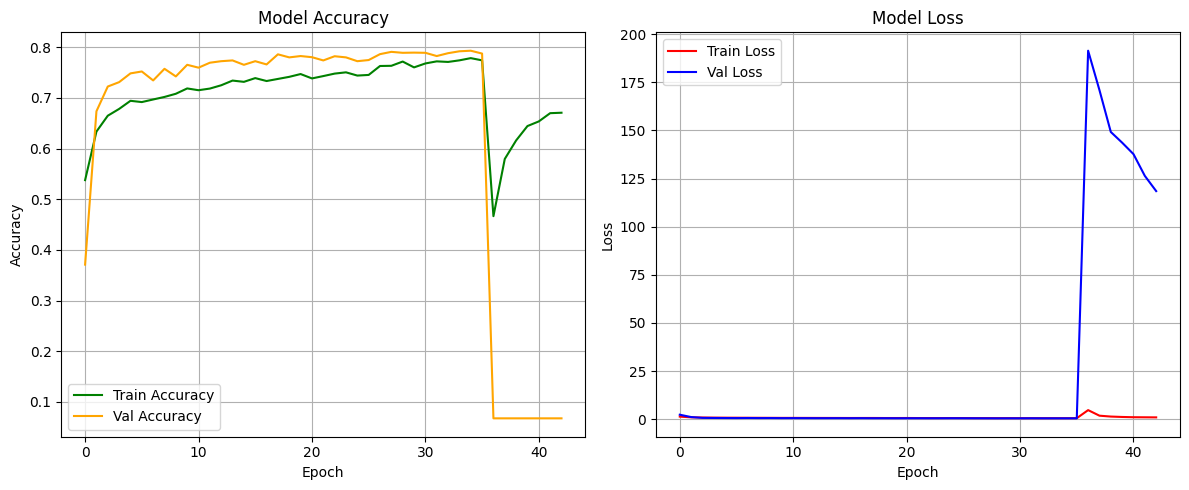

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluate on test set

In [16]:
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}, Test Loss: {test_loss:.2f}")


Evaluating on test data...
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.0677 - loss: 191.2993
Test accuracy: 6.77, Test Loss: 191.30


Making it LightWeight

In [10]:
model = tf.keras.models.load_model("model/best_model.h5")
# model.summary()

In [11]:
print("\nEvaluating model on test data...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Model - Test accuracy: {test_acc*100:.2f}%, Test Loss: {test_loss:.2f}")


Evaluating model on test data...


e:\PROJECTS\Krishi-Sahayak\krishi-model\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 905ms/step - accuracy: 0.9188 - loss: 0.2127
Model - Test accuracy: 91.88%, Test Loss: 0.21


Pruning

In [ ]:
# def prune_weights(model, amount=0.2):
#     """Set the smallest weights in each layer to zero."""
#     for layer in model.layers:
#         if hasattr(layer, 'kernel'):
#             w = layer.kernel.numpy()
#             threshold = np.percentile(np.abs(w), amount*100)
#             w[np.abs(w) < threshold] = 0
#             layer.kernel.assign(w)
#     return model

# model_pruned = prune_weights(model, amount=0.2)
# loss, acc = model_pruned.evaluate(test_generator)
# print(f"Accuracy after pruning: {acc*100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 842ms/step - accuracy: 0.5262 - loss: 2.9732
Accuracy after pruning: 52.62%


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: full integer quantization using train_generator
def representative_dataset():
    for i, (images, labels) in enumerate(train_generator):
        if i >= 100:  # use first 100 batches
            break
        yield [images.astype(np.float32)]

converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpij677sqk\assets


INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpij677sqk\assets


Saved artifact at 'C:\Users\piyus\AppData\Local\Temp\tmpij677sqk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  2540989294416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540985643664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540989293840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540985641552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540989293648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540985643472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540989928208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540989928592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540985641744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2540989294032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25409

e:\PROJECTS\Krishi-Sahayak\krishi-model\venv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [17]:
with open("model_pruned_quantized.tflite", "wb") as f:
    f.write(tflite_model)

print("Pruned + quantized TFLite model saved!")

Pruned + quantized TFLite model saved!
